In [1]:
import os

In [2]:
# Load Images
# Data Directory
data_dir = 'data/SASE-FE/frames'
real = 'data/SASE-FE/frames/real'
fake = 'data/SASE-FE/frames/fake'
# List directories in real and fake
real_emotions = os.listdir(real)
fake_emotions = os.listdir(fake)

real_emotions.remove('.DS_Store')
fake_emotions.remove('.DS_Store')

In [3]:
# Length of real and fake emotions
print(len(real_emotions))
print(len(fake_emotions))


6
6


In [4]:
print("-------------------------")
print("Real emotions:\n")
# How many images in each emotion
for emotion in real_emotions:
    print(emotion, len(os.listdir(os.path.join(real, emotion))))

print("\n-------------------------")
print("Fake emotions:\n")

for emotion in fake_emotions:
    print(emotion, len(os.listdir(os.path.join(fake, emotion))))



-------------------------
Real emotions:

happy 5348
contempt 5222
sad 5407
surprise 5438
angry 5402
disgust 5307

-------------------------
Fake emotions:

happy 4937
contempt 5689
sad 5281
surprise 5187
angry 5850
disgust 5524


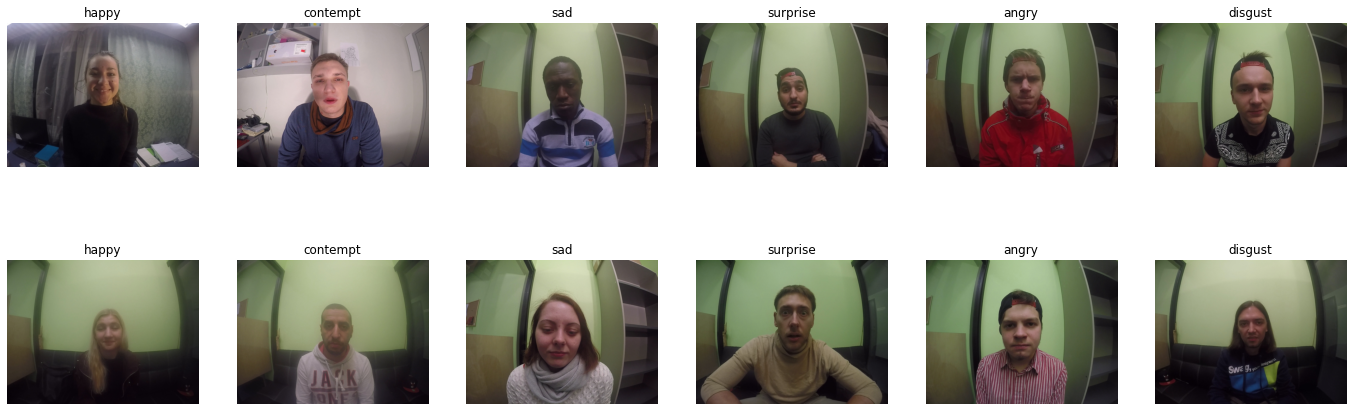

In [5]:
# Plot real and fake emotions images together
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(24, 8))
for i in range(6):
    plt.subplot(2, 6, i+1)
    img_1 = plt.imread(real + "/" + real_emotions[i] + "/" + os.listdir(real + "/" + real_emotions[i])[0])
    plt.imshow(img_1)
    plt.title(real_emotions[i])
    plt.axis("off")

    plt.subplot(2, 6, i+7)
    img_2 = plt.imread(fake + "/" + fake_emotions[i] + "/" + os.listdir(fake + "/" + fake_emotions[i])[0])
    plt.imshow(img_2)
    plt.title(fake_emotions[i])
    plt.axis("off")
plt.show()


In [6]:
# Show image details
img = plt.imread(real + "/" + real_emotions[0] + "/" + os.listdir(real + "/" + real_emotions[0])[0])
print("Image shape:", img.shape)


Image shape: (960, 1280, 3)


Reshaped image shape: (224, 224, 3)


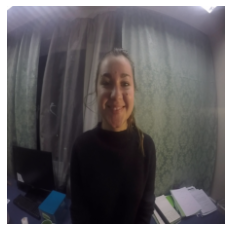

In [7]:
# reshpaing the image to 224 x 224
from skimage.transform import resize
img = resize(img, (224, 224))
print("Reshaped image shape:", img.shape)

# Plot reshaped image
plt.imshow(img)
plt.axis("off")
plt.show()


/Users/dim__gag/opt/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


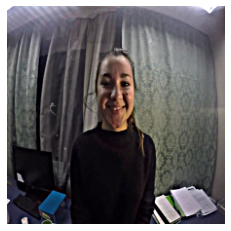

In [8]:
# Sharpen the image and zoom in the face
from skimage import filters
from skimage import exposure

# Sharpen the image
img_sharpen = filters.unsharp_mask(img, radius=3, amount=2)
plt.imshow(img_sharpen)
plt.axis("off")
plt.show()


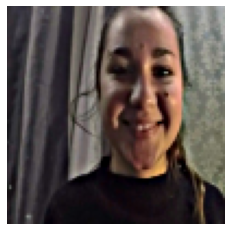

In [9]:
# Zoom in the face
img_zoom = img_sharpen[50:150, 50:150]
plt.imshow(img_zoom)
plt.axis("off")
plt.show()

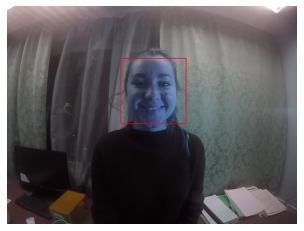

In [27]:
# Data Preprocessing to detect faces
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Read the input image
img = cv2.imread(real + "/" + real_emotions[0] + "/" + os.listdir(real + "/" + real_emotions[0])[0])

# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur the image background
gray = cv2.GaussianBlur(gray, (25, 25), 0)

# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Display the output
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# Code template for the function to predict the emotion
# 
# Importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Defining the VGGFace model
class VGGFace(nn.Module):
    def __init__(self):
        super(VGGFace, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2622),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Loading the model
model = VGGFace()
model.load_state_dict(torch.load('data/SASE-FE/vgg_face_dag.pth'))

# Defining the preprocessing function
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

# Defining the postprocessing function
from scipy.spatial.distance import cosine

def postprocess(output):
    output = output.squeeze(0)
    output = F.normalize(output, p=2, dim=0)
    return output

# Defining the function to predict the emotion
def predict_emotion(image):
    # Preprocess the image
    image_tensor = preprocess(image)
    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor.unsqueeze_(0)
    # Turn the input into a Variable
    input = torch.autograd.Variable(image_tensor)
    # Predict the emotion
    output = model(input)
    # Postprocess the output
    output = postprocess(output)
    return output

# Predicting the emotion
output = predict_emotion(img_zoom)
print(output.shape)

# Defining the function to find the most similar emotion
def find_most_similar_emotion(embedding):
    # Load the emotions embeddings
    emotions = torch.load('data/SASE-FE/emotions.pt')
    # Find the most similar emotion
    min_distance = 1
    for emotion in emotions:
        distance = cosine(emotion, embedding)
        if distance < min_distance:
            min_distance = distance
            most_similar_emotion = emotion
    return most_similar_emotion

# Finding the most similar emotion
most_similar_emotion = find_most_similar_emotion(output)
print(most_similar_emotion.shape)

# Defining the function to find the emotion label
def find_emotion_label(embedding):
    # Load the emotions embeddings
    emotions = torch.load('data/SASE-FE/emotions.pt')
    # Load the emotions labels
    emotions_labels = torch.load('data/SASE-FE/emotions_labels.pt')
    # Find the most similar emotion
    min_distance = 1
    for i, emotion in enumerate(emotions):
        distance = cosine(emotion, embedding)
        if distance < min_distance:
            min_distance = distance
            most_similar_emotion = emotion
            most_similar_emotion_label = emotions_labels[i]
    return most_similar_emotion_label

# Finding the emotion label
most_similar_emotion_label = find_emotion_label(output)
print(most_similar_emotion_label)

# Plotting the image and the predicted emotion
plt.imshow(img_zoom)
plt.title(most_similar_emotion_label)
plt.axis("off")
plt.show()

